**1. Import các thư viện cần thiết**

In [15]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error as msle

**2. Đọc file dữ liệu và chia dataset theo tỉ lệ 7:3**

In [16]:
# Đọc file dữ liệu
df = pd.read_csv('D:\BID.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.7 * len(df))
test_size = int(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


**Xem** **lại** **dataset**

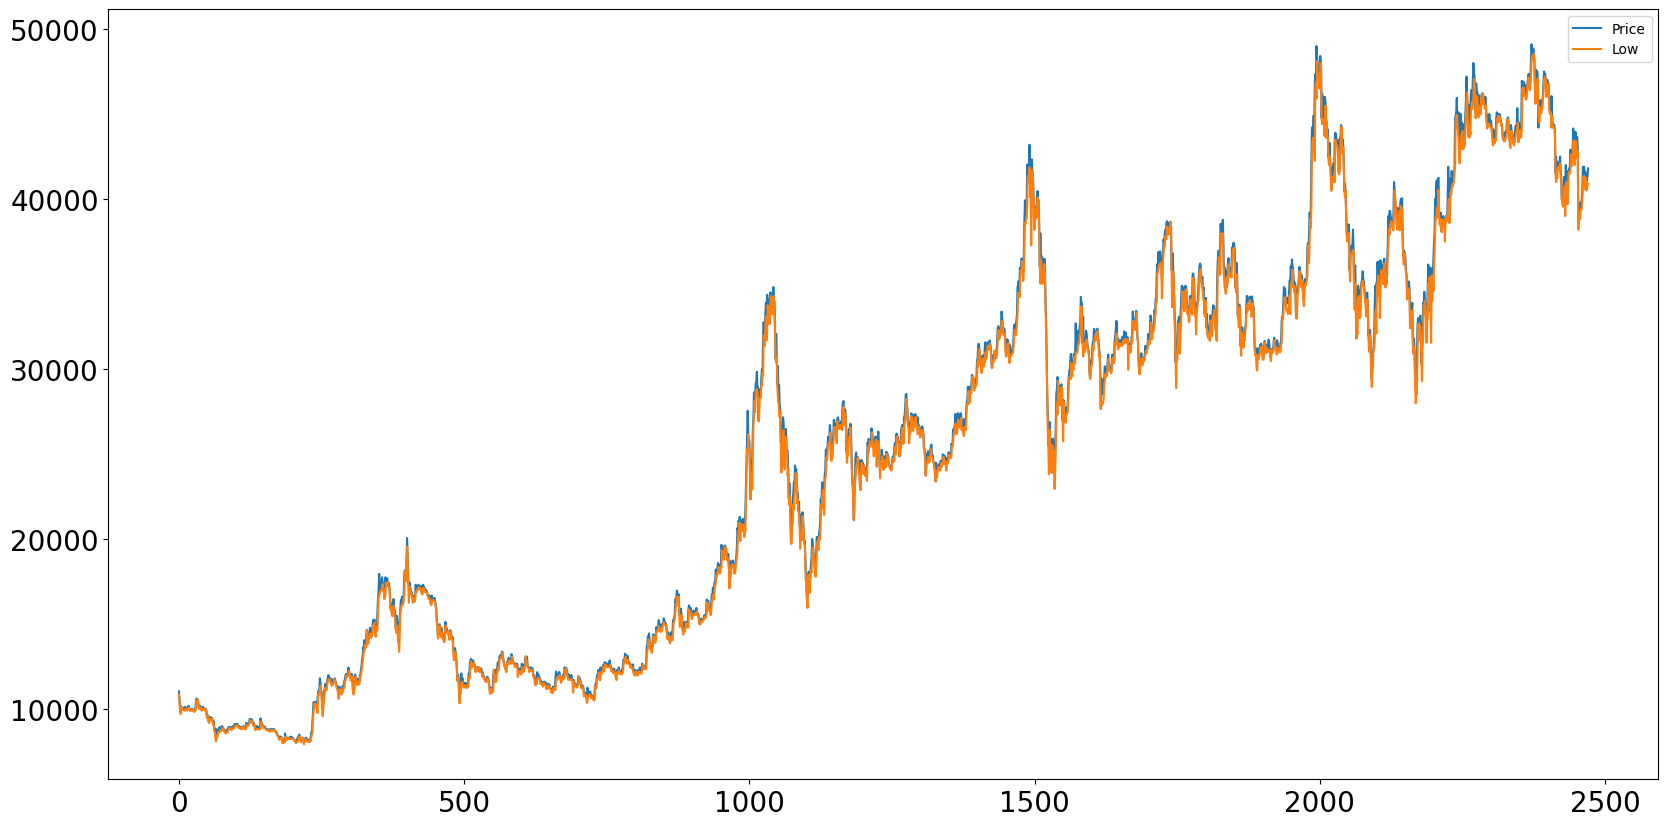

In [17]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [18]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.2112075330694403,
 0.6687560278478504,
 1,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 38486.18864029625)

In [19]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [20]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-51.3605244441914,
 0.0,
 0,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 38471.01317565339)

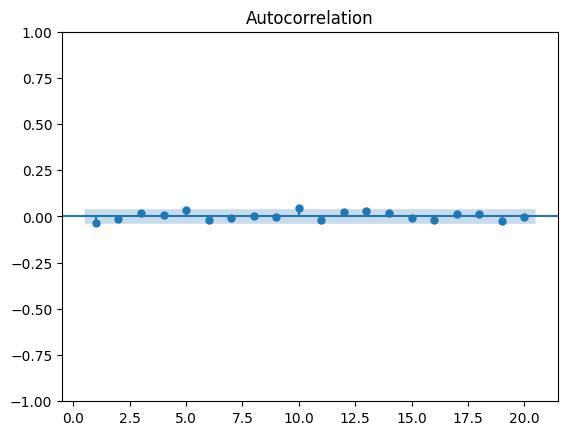

In [21]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [22]:
df

,Price,Low
0,11054.8,10874.6
1,10574.2,10574.2
2,9973.4,9913.3
3,10213.7,9733.1
4,10153.6,10153.6
...,...,...
2466,41500.0,41250.0
2467,41000.0,40500.0
2468,41200.0,40550.0
2469,41300.0,40800.0


In [23]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=26492.404, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=26490.899, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=26494.873, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=26494.878, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=26490.469, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=26492.880, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=26492.883, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=26489.336, Time=0.27 sec
 ARIMA(0,1,0)(2,0,1)[5] intercept   : AIC=26486.397, Time=0.38 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=26484.504, Time=0.15 sec
 ARIMA(1,1,0)(2,0,0)[5] intercept   : AIC=26486.503, Time=0.18 sec
 ARIMA(0,1,1)(2,0,0)[5] intercept   : AIC=26486.518, Time=0.18 sec
 ARIMA(1,1,1)(2,0,0)[5] intercept   : AIC=26487.104, Time=0.59 sec
 ARIMA(0,1,0)(2,0,0)[5]             : AIC=26483.813, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0

**Dùng SARIMAX để train model**

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(0,1,0), seasonal_order=(2,0,0,5))
model_fit = model1.fit()

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [25]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([37790.8, 37711.6, 37632.5, 38384.3, 38146.9, 37909.5, 37909.5,
       38305.2, 37988.6, 38661.3, 38463.5, 35812.2, 33635.8, 35772.6,
       35693.5, 35139.5, 33081.7, 32132. , 30430.5, 28887.2, 30588.7,
       30509.6, 31419.7, 32369.5, 32686. , 30905.3, 31419.7, 32329.9,
       33002.6, 33912.8, 34585.5, 34189.8, 33714.9, 33398.3, 33477.5,
       34506.3, 34704.2, 34585.5, 33477.5, 33240. , 33477.5, 32844.3,
       32765.2, 33675.3, 34110.6, 33873.2, 33477.5, 33200.5, 34466.8,
       35376.9, 35218.6, 34110.6, 33160.9, 33200.5, 32052.9, 33358.8,
       33477.5, 33873.2, 34031.5, 34862.5, 35693.5, 35653.9, 35891.3,
       35376.9, 34862.5, 34902. , 34427.2, 34031.5, 34031.5, 33121.3,
       33081.7, 33991.9, 32448.6, 32329.9, 32052.9, 31815.5, 31934.2,
       32132. , 31657.2, 32844.3, 32606.9, 32052.9, 31934.2, 33081.7,
       33081.7, 33240. , 33477.5, 33002.6, 32290.3, 32132. , 31657.2,
       33121.3, 36010. , 35970.5, 36564. , 35653.9, 35535.2, 37592.9,
       37988.6, 3735

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [26]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[44120.80719304 44136.32481679 44151.84244054 44167.36006428
 44182.87768803 44198.39531178 44213.91293553 44229.43055928
 44244.94818302 44260.46580677 44275.98343052 44291.50105427
 44307.01867802 44322.53630176 44338.05392551 44353.57154926
 44369.08917301 44384.60679676 44400.12442051 44415.64204425
 44431.159668   44446.67729175 44462.1949155  44477.71253925
 44493.23016299 44508.74778674 44524.26541049 44539.78303424
 44555.30065799 44570.81828173]


***7.Đánh giá độ chính xác thuật toán***

In [27]:
#MSLE
test_msle = msle(y_test, y_pred_test)
print('Testing MSLE:', test_msle)

#RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Testing MAE:', test_mae)

Testing MSLE: 0.0004507949228855969
Testing RMSE: 794.6850545920081
Testing MAPE: 1.379690626508103
Testing MAE: 529.1809716599191


**8. Vẽ biểu đồ**

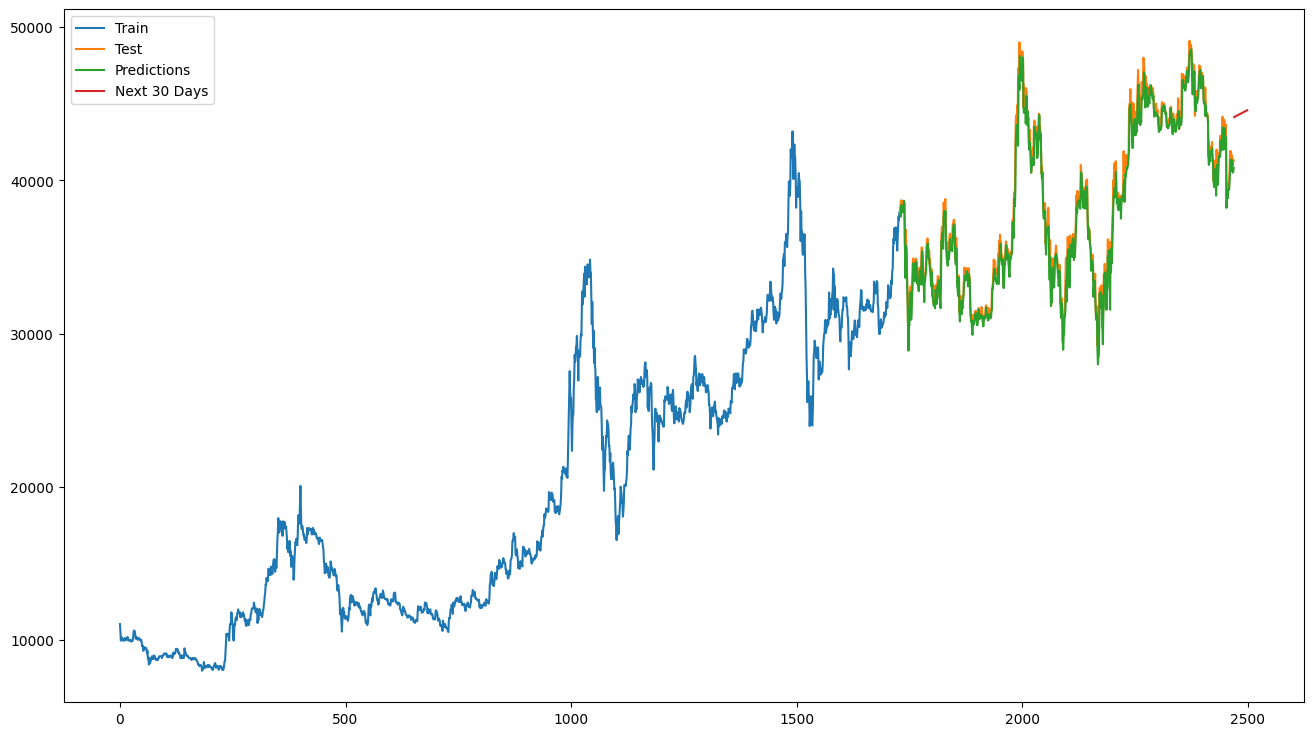

In [28]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next 30 Days'])
plt.show()